# Time series prediction using RNNs, with TensorFlow

This notebook illustrates:

* Creating a Recurrent Neural Network in TensorFlow
* Creating a Custom Estimator in tf.contrib.learn


This notebook was modified based on [the work](http://dataconomy.com/2017/05/how-to-do-time-series-prediction-using-rnns-tensorflow-and-cloud-ml-engine/) originally published by VALLIAPPA LAKSHMANAN.

Send any feedback to datalab-feedback@google.com.

# Data

We simulate a set of sinusoids with random amplitudes and frequencies.



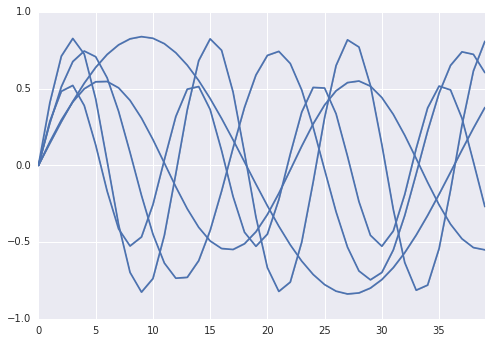

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

SEQ_LEN = 40

def create_time_series():
  freq = (np.random.random() * 0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0, SEQ_LEN) * freq) * ampl
  return x

for i in xrange(0, 5):
  sns.tsplot( create_time_series() );  # 5 series

In [2]:
# Save the data to disk.

def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in xrange(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

to_csv('train.csv', 1000)
to_csv('eval.csv',  100)

In [3]:
!head -1 valid.csv

0.0,0.224950746159,0.441402896518,0.641178930587,0.816731348332,0.961427813272,1.06980172087,1.13775872581,1.16273142554,1.14377635628,1.0816096369,0.978579914072,0.83857963084,0.666897970903,0.470021034261,0.255386793604,0.031104089145,-0.194353721802,-0.412468886628,-0.615001056476,-0.794298605034,-0.943587705503,-1.05722824446,-1.13092690427,-1.16189936377,-1.14897548942,-1.0926435427,-0.995031733697,-0.859827817718,-0.692139772633,-0.498302820441,-0.285640083809,-0.0621859199053,0.163617616057,0.383239710045,0.588383081708,0.771297454034,0.925072357319,1.04389820538,1.12328578059


Our CSV file sequences consist of 40 numbers. Each number is one input and the prediction output is the next number given previous numbers as history. With 40 numbers (one instance) input, we will have 40 output numbers. For training, each instance's 0~38 numbers are inputs, and 1~39 are truth. For prediction, it is like "given a series of numbers, predict next n numbers".

# Model

We will create a recurrent neural network model based on TensorFlow.

For more info on RNN, see:

* http://colah.github.io/posts/2015-08-Understanding-LSTMs/ for the theory
* https://www.tensorflow.org/tutorials/recurrent for explanations
* https://github.com/tensorflow/models/tree/master/tutorials/rnn/ptb for sample code


We will use TensorFlow's [Estimator](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/Estimator) to build our model. Estimators help construct the training/evaluation/prediction graph. They reuse the common graph, and fork only when needed (i.e. input_fn). They also handle model export. Models exported can be deployed to Google Cloud ML Engine for online prediction.

In [4]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
from tensorflow.contrib.learn.python.learn.utils import saved_model_export_utils
import tensorflow.contrib.rnn as rnn


# tf.decode_csv requires DEFAULTS to infer data types and default values.
DEFAULTS = [[0.0] for x in xrange(0, SEQ_LEN)]

# The Estimator API requires named features.
TIMESERIES_FEATURE_NAME = 'rawdata'

# Training batch size.
BATCH_SIZE = 25

## Input

Our CSV file structure is quite simple -- a bunch of floating point numbers (note the type of DEFAULTS). We ask for the data to be read BATCH_SIZE sequences at a time.

In [5]:
def create_input_fn(filename, mode=tf.contrib.learn.ModeKeys.TRAIN):  
  """Creates an input_fn for estimator in training or evaluation."""
  
  def _input_fn():
    """Returns named features and labels, as required by Estimator."""

    num_epochs = 100 if mode == tf.contrib.learn.ModeKeys.TRAIN else 1
    
    # could be a path to one file or a file pattern.
    input_file_names = tf.train.match_filenames_once(filename)
    
    filename_queue = tf.train.string_input_producer(
        input_file_names, num_epochs=num_epochs, shuffle=True)
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=BATCH_SIZE)

    # all_data is a list of tensors
    batch_data = tf.decode_csv(value, record_defaults=DEFAULTS)
    
    # Make the shape [BATCH_SIZE, SEQ_LEN]. BATCH_SIZE is usually the leftmost dimension.
    batch_data = tf.transpose(batch_data)

    # Get x and y. They are both of shape [BATCH_SIZE, SEQ_LEN - 1]
    x = tf.slice(batch_data, [0, 0], [BATCH_SIZE, SEQ_LEN-1])
    y = tf.slice(batch_data, [0, 1], [BATCH_SIZE, SEQ_LEN-1])
    
    return {TIMESERIES_FEATURE_NAME: x}, y   # dict of features, target

  return _input_fn

## Inference Graph

Following Estimator's requirements, we will create a model_fn representing the inference model. Note that this function defines the graph that will be used in training, evaluation and prediction.

To supply a model function to the Estimator API, you need to return a ModelFnOps. The rest of the function creates the necessary objects.

In [6]:
#  We will define one LSTM layer. That's the size of LSTM units.
LSTM_SIZE = 10


def model_fn(features, targets, mode):
  """Define the inference model."""

  uniform_initializer = tf.random_uniform_initializer(minval=-0.08, maxval=0.08)
  input_seq = features[TIMESERIES_FEATURE_NAME]

  # RNN requires input tensor rank > 2. Adding one dimension.
  input_seq = tf.expand_dims(input_seq, axis=-1)
  
  # LSTM output will be [BATCH_SIZE, SEQ_LEN - 1, lstm_output_size]
  lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE)
  lstm_outputs, _ = tf.nn.dynamic_rnn(cell=lstm_cell,
                                      inputs=input_seq,
                                      dtype=tf.float32)
  
  # Reshape to [BATCH_SIZE * (SEQ_LEN - 1), lstm_output] so it is 2-D and can
  # be fed to next layer.
  lstm_outputs = tf.reshape(lstm_outputs, [-1, lstm_cell.output_size])
  
  # Add hidden layers on top of LSTM layer to add some "nonlinear" to the model.
  hidden1 = tf.contrib.layers.fully_connected(inputs=lstm_outputs,
                                              num_outputs=100,
                                              activation_fn=None,
                                              weights_initializer=uniform_initializer,
                                              biases_initializer=uniform_initializer)
  
  hidden2 = tf.contrib.layers.fully_connected(inputs=lstm_outputs,
                                              num_outputs=50,
                                              activation_fn=None,
                                              weights_initializer=uniform_initializer,
                                              biases_initializer=uniform_initializer)  
    
  predictions = tf.contrib.layers.fully_connected(inputs=hidden2,
                                                  num_outputs=1,
                                                  activation_fn=None,
                                                  weights_initializer=uniform_initializer,
                                                  biases_initializer=uniform_initializer)
  
  # predictions are all we need when mode is not train/eval. 
  predictions_dict = {"predicted": predictions}

  # If train/evaluation, we'll need to compute loss.
  # If train, we will also need to create an optimizer.
  loss, train_op, eval_metric_ops = None, None, None
  if mode == tf.contrib.learn.ModeKeys.TRAIN or mode == tf.contrib.learn.ModeKeys.EVAL:
    # Note: The reshape below is needed because Estimator needs to know
    # loss shape. Without reshaping below, loss's shape would be unknown.
    targets = tf.reshape(targets, [BATCH_SIZE * (SEQ_LEN - 1)])
    predictions = tf.reshape(predictions, [BATCH_SIZE * (SEQ_LEN - 1)])
    loss = tf.losses.mean_squared_error(targets, predictions)
    eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(targets, predictions)
    }

    if mode == tf.contrib.learn.ModeKeys.TRAIN:
      # The learning rate here is unusually high, because we don't add any noise
      # to training/evaluation data and overfitting is not a big problem.
      train_op = tf.contrib.layers.optimize_loss(
          loss=loss,
          global_step=tf.contrib.framework.get_global_step(),
          learning_rate=0.1,
          optimizer="Adagrad")
  
  # return ModelFnOps as Estimator requires.
  return tflearn.ModelFnOps(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops)

## Training

Distributed training is launched off using an Experiment.  The key line here is that we use tflearn.Estimator rather than, say tflearn.DNNRegressor.  This allows us to provide a model_fn, which will be our RNN defined above.  Note also that we specify a serving_input_fn -- this is how we parse the input data provided to us at prediction time using gcloud or Cloud ML Online Prediction.

In [7]:
def get_train():
  return create_input_fn('train.csv', mode=tf.contrib.learn.ModeKeys.TRAIN)


def get_eval():
  return create_input_fn('eval.csv', mode=tf.contrib.learn.ModeKeys.EVAL)


def serving_input_fn():
  feature_placeholders = {
      TIMESERIES_FEATURE_NAME: tf.placeholder(tf.float32, [None, None])
  }
  return tflearn.utils.input_fn_utils.InputFnOps(
      feature_placeholders,
      None,
      feature_placeholders
  )


def experiment_fn(output_dir):
    """An experiment_fn required for Estimator API to run training."""

    estimator = tflearn.Estimator(model_fn=model_fn,
                                  model_dir=output_dir,
                                  config=tf.contrib.learn.RunConfig(save_checkpoints_steps=500))
    return tflearn.Experiment(
        estimator,
        train_input_fn=get_train(),
        eval_input_fn=get_eval(),
        export_strategies=[saved_model_export_utils.make_export_strategy(
            serving_input_fn,
            default_output_alternative_key=None,
            exports_to_keep=1
        )]
    )


shutil.rmtree('training', ignore_errors=True) # start fresh each time.
learn_runner.run(experiment_fn, 'training')

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b08fca3d0>, '_model_dir': 'training', '_save_checkpoints_steps': 500, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into training/model.ckpt.
INFO:tensorflow:loss = 0.522165, step = 1
INFO:tensorflow:Starting evaluation at 2017-09-14-22:17:48
INFO:tensorflow:Restoring parameters from training/model.ckpt-1
INFO:tensorflow:Evaluation [1/100

({'global_step': 4000, 'loss': 0.0015589965, 'rmse': 0.039484128},
 ['training/export/Servo/1505427524'])

## Model Summary

We can plot model's training summary events using Datalab's ML library.

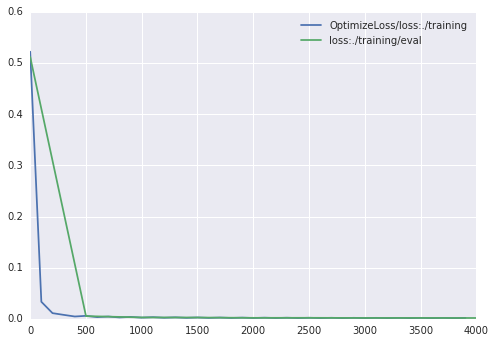

In [8]:
from google.datalab.ml import Summary

summary = Summary('./training')
summary.plot(['OptimizeLoss/loss', 'loss'])

# Prediction

We will generate another instance for prediction which is independent on training or evaluation data.

x
[0.0, 0.49206750119423392, 0.92351932150802074, 1.2412067653011143, 1.4059952815902632, 1.3975852812095435, 1.2170127559650492, 0.88652165925632853, 0.44682376904739124, -0.047916421107471997, -0.5367539932602633, -0.95947114760897956, -1.2639951744775999, -1.4128130676458441, -1.3875925903785205, -1.1914405448886962, -0.84852005872411995, -0.40107403292229543, 0.095778579435334674, 0.58083264018745406, 0.99433642404239475, 1.2853521768420846, 1.4180309185988655, 1.3760285252841651, 1.164519091230976, 0.80955755468792523, 0.35487010194390123, -0.14353227365366927, -0.62425352526983391, -1.0280756677507377]

y
[-1.305253586733669, -1.4216429255126888, -1.3629061816106112, -1.1362788820957421, -0.76967827009600887, -0.30826429958849971, 0.19112342526234968, 0.66696747668147693, 1.0606506708482104, 1.3236768668719401]


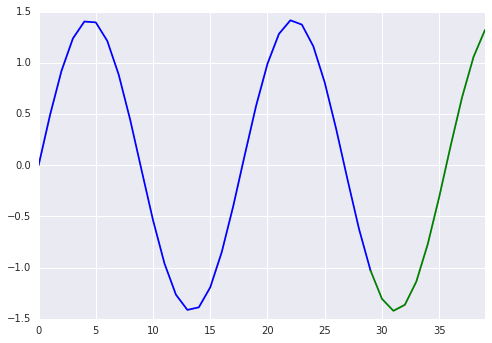

In [12]:
prediction_data = create_time_series()

# First 30 values as x, Last 10 values as y.
prediction_x = list(prediction_data[:30])
prediction_y = list(prediction_data[30:])

print('x\n%s\n' % prediction_x)
print('y\n%s' % prediction_y)

sns.tsplot(prediction_x, color='blue')
y_truth_curve = [np.nan] * (len(prediction_x)-1) + [prediction_x[-1]] + prediction_y
sns.tsplot(y_truth_curve, color='green')

First prediction we will do is just sending x, and for each value in x it will return a predicted value. And then we can compare the predicted values with the truth (x+1).

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9a31cbf210>, '_model_dir': 'training', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
INFO:tensorflow:Restoring parameters from training/model.ckpt-4000


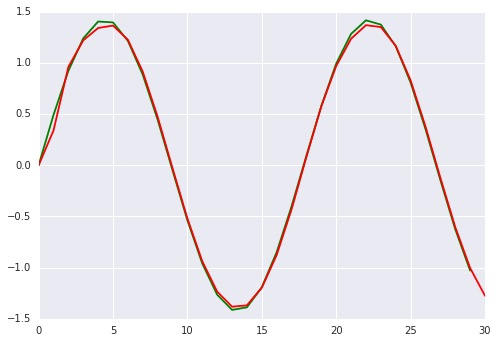

In [13]:
# Load model.
estimator = tflearn.Estimator(model_fn=model_fn, model_dir='training')

# Feed Prediction data.
predict_input_fn = lambda: {TIMESERIES_FEATURE_NAME: [prediction_x]}

predicted = list(estimator.predict(input_fn=predict_input_fn))
predicted = [p['predicted'] for p in predicted]

# Plot prediction source.
sns.tsplot(prediction_x, color='green')

# Plot predicted values.
sns.tsplot([prediction_x[0]] + predicted, color='red')

The next prediction is sending x, and predict next n values. We make n predictions and take only the last predicted value each time, append it to x for next prediction source.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9a59dc48d0>, '_model_dir': 'training', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
INFO:tensorflow:Restoring parameters from training/model.ckpt-4000
INFO:tensorflow:Restoring parameters from training/model.ckpt-4000
INFO:tensorflow:Restoring parameters from training/model.ckpt-4000
INFO:tensorflow:Restoring parameters from training/model.ckpt-4000
INFO:tensorflow:Restoring parameters from training/model.ckpt-4000
INFO:tensorflow:Restorin

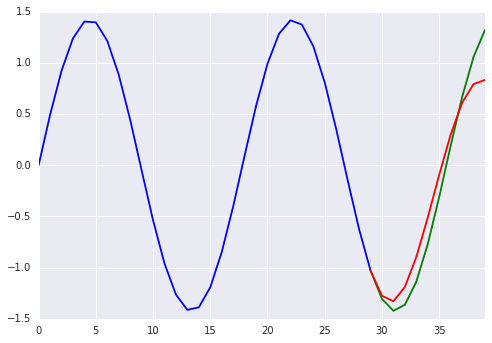

In [14]:
estimator = tflearn.Estimator(model_fn=model_fn, model_dir='training')

# Prediction data starts with x.
x_total = list(prediction_x)

# Make n predictions.
for i in range(len(prediction_y)):
  predict_input_fn = lambda: {TIMESERIES_FEATURE_NAME: [x_total]}
  p = list(estimator.predict(input_fn=predict_input_fn))
  # For each step, append the tail element of last predicted values.  
  x_total.append(p[-1]['predicted'])

# The first len(prediction_x) elements are prediction source. So remove them.
y_predicted = x_total[len(prediction_x):]

# Zero out prediction source (making them nan), add the last value of prediction source
# so the first edge in the curve is plotted, and add predicted values.
y_predicted_curve = [np.nan] * (len(prediction_x)-1) + [prediction_x[-1]] + y_predicted

# Plot prediction source.
sns.tsplot(prediction_x, color='blue')

# Plot truth curve.
sns.tsplot(y_truth_curve, color='green')

# Plot predicted curve.
sns.tsplot(y_predicted_curve, color='red')